# Сравнение алгоритмов градиентного бустинга или история знает только первых...

![](img/gb-img-04.jpg)

Всем привет ! Данная статья написана по итогам проектной работы на курсе OTUS ML Basic и в ней мы проведем сравнение алгоритмов градиентного бустинга. Почему бустинг, спросите вы ? Понятно, что нейронные сети интереснее, но не всегда их применение целесообразно и есть задачи для которых классические методы машинного обучения являются лучшим выбором. Бустинг является одним из наиболее эффективных классических алгоритмов и поскольку существуют различные реализации, то мы проведем сравнение, чтобы понять, кто из них демонстрирует лучшие результаты. Познакомимся с участниками турнира, чьи реализации алгоритма градиентного бустинга будут участвовать в сравнении: 

- Sklearn;
- XGBoost;
- LightGBM;
- Catboost;

Напомню, что бустинг реализует идею построения "сильной" модели на основе композиции базовых алгоритмов (как правило, деревьев решений), точность предсказания которых  может быть лишь немногим выше случайного угадывания. Общий подход к реализации выглядит следующим образом:

- строим алгоритмы последовательно;
- каждый следующий строится на ошибках предыдущего;
- решение принимается методом взвешенного голосования;

Проводить сравнение алгоритмов бустинга мы будем на [наборе данных](https://www.kaggle.com/datasets/blastchar/telco-customer-churn) для классификации, а именно, предсказания оттока клиентов телеком оператора. В статье мы рассмотрим наиболее интересные моменты, а полную версию jupyter ноутбука все интересующиеся могут найти [здесь](https://github.com/DzenGarden/Otus-ML/blob/main/articles/ensemble-of-models/boosting-algorithms.ipynb).

<details>
<summary> Подключаем необходимые библиотеки (убрать под спойлер) </summary>

In [12]:
import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.preprocessing import LabelEncoder, StandardScaler

from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings("ignore")

</details>

Загрузим датасет 

In [16]:
df = pd.read_csv('data/WA_Fn-UseC_-Telco-Customer-Churn.csv', index_col=0)

In [18]:
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
customerID,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


Посмотрим на основные параметры набора данных

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   object 
 6   MultipleLines     7043 non-null   object 
 7   InternetService   7043 non-null   object 
 8   OnlineSecurity    7043 non-null   object 
 9   OnlineBackup      7043 non-null   object 
 10  DeviceProtection  7043 non-null   object 
 11  TechSupport       7043 non-null   object 
 12  StreamingTV       7043 non-null   object 
 13  StreamingMovies   7043 non-null   object 
 14  Contract          7043 non-null   object 
 15  PaperlessBilling  7043 non-null   object 
 16  PaymentMethod     7043 non-null 

В наборе данных всего лишь 3 признака из 20 имеют числовой тип, поэтому, первое что необходимо сделать, это преобразовать категориальные признаки в числовые, а также провести другую предобработку данных, при необходимости.

# Preprocessing & Feature Engineering

Проверим, есть ли в наборе данных пропущенные значения

In [35]:
df.isna().sum()

gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

Пропусков в данных нет и это хорошо, но есть 17 категориальных признаков, которые необходимо привести к числовому виду:

In [38]:
df.select_dtypes(include='object').columns

Index(['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
       'PaperlessBilling', 'PaymentMethod', 'TotalCharges', 'Churn'],
      dtype='object')

Посмотрим на количество уникальных значений для каждого из атрибутов

In [41]:
df.nunique()

gender                 2
SeniorCitizen          2
Partner                2
Dependents             2
tenure                73
PhoneService           2
MultipleLines          3
InternetService        3
OnlineSecurity         3
OnlineBackup           3
DeviceProtection       3
TechSupport            3
StreamingTV            3
StreamingMovies        3
Contract               3
PaperlessBilling       2
PaymentMethod          4
MonthlyCharges      1585
TotalCharges        6531
Churn                  2
dtype: int64

<details>
<summary> Заменим бинарные категориальные признаки значениями 0/1 (убрать под спойлер) </summary>

In [45]:
bin_cat_cols_list = []
for index, value in df.nunique().items():
    if value == 2:
        bin_cat_cols_list.append(index)
        print(f"Index : {index}, Value : {value}")

Index : gender, Value : 2
Index : SeniorCitizen, Value : 2
Index : Partner, Value : 2
Index : Dependents, Value : 2
Index : PhoneService, Value : 2
Index : PaperlessBilling, Value : 2
Index : Churn, Value : 2


In [47]:
bin_cat_cols_list

['gender',
 'SeniorCitizen',
 'Partner',
 'Dependents',
 'PhoneService',
 'PaperlessBilling',
 'Churn']

In [49]:
for col in bin_cat_cols_list:
    print(col, df[col].unique())

gender ['Female' 'Male']
SeniorCitizen [0 1]
Partner ['Yes' 'No']
Dependents ['No' 'Yes']
PhoneService ['No' 'Yes']
PaperlessBilling ['Yes' 'No']
Churn ['No' 'Yes']


атрибут SeniorCitizen уже имеет значения 0/1, поэтому исключим его из дальнейшей обработки

In [52]:
bin_cat_cols_list.remove('SeniorCitizen')

In [54]:
for col in bin_cat_cols_list:
    print(col, df[col].unique())

gender ['Female' 'Male']
Partner ['Yes' 'No']
Dependents ['No' 'Yes']
PhoneService ['No' 'Yes']
PaperlessBilling ['Yes' 'No']
Churn ['No' 'Yes']


Итого, у нас 6 бинарных категориальных признаков - заменим их значениями 0/1

In [56]:
g_dict = {'Female':0, 'Male':1}

In [58]:
df['gender'] = df['gender'].map(g_dict)

In [60]:
yn_dict = {'Yes':1, 'No':0}

In [62]:
for col in bin_cat_cols_list[1:]:
    df[col] = df[col].map(yn_dict)

</details>

Посмотрим, что у нас получилось по итогам преобразования бинарных атрибутов 

In [65]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   int64  
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   int64  
 3   Dependents        7043 non-null   int64  
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   int64  
 6   MultipleLines     7043 non-null   object 
 7   InternetService   7043 non-null   object 
 8   OnlineSecurity    7043 non-null   object 
 9   OnlineBackup      7043 non-null   object 
 10  DeviceProtection  7043 non-null   object 
 11  TechSupport       7043 non-null   object 
 12  StreamingTV       7043 non-null   object 
 13  StreamingMovies   7043 non-null   object 
 14  Contract          7043 non-null   object 
 15  PaperlessBilling  7043 non-null   int64  
 16  PaymentMethod     7043 non-null 

Поработаем с оставшимися 11 категориальными признаками и начнем с приведения TotalCharges к типу float

In [18]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

In [19]:
df.isna().sum()

gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

Видим, что есть 11 пропущенных значений в Total Charges, записей немного, поэтому, просто удалим их из набора данных

In [20]:
df.dropna(inplace = True)

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7032 non-null   int64  
 1   SeniorCitizen     7032 non-null   int64  
 2   Partner           7032 non-null   int64  
 3   Dependents        7032 non-null   int64  
 4   tenure            7032 non-null   int64  
 5   PhoneService      7032 non-null   int64  
 6   MultipleLines     7032 non-null   object 
 7   InternetService   7032 non-null   object 
 8   OnlineSecurity    7032 non-null   object 
 9   OnlineBackup      7032 non-null   object 
 10  DeviceProtection  7032 non-null   object 
 11  TechSupport       7032 non-null   object 
 12  StreamingTV       7032 non-null   object 
 13  StreamingMovies   7032 non-null   object 
 14  Contract          7032 non-null   object 
 15  PaperlessBilling  7032 non-null   int64  
 16  PaymentMethod     7032 non-null 

<details>
<summary> Преобразуем оставшиеся категориальные признаки, применив LabelEncoder (убрать под спойлер) </summary>

In [22]:
obj_cols = df.select_dtypes(include='object').columns

In [23]:
obj_cols

Index(['MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
       'Contract', 'PaymentMethod'],
      dtype='object')

In [24]:
for col in obj_cols:
    print(col, df[col].unique())

MultipleLines ['No phone service' 'No' 'Yes']
InternetService ['DSL' 'Fiber optic' 'No']
OnlineSecurity ['No' 'Yes' 'No internet service']
OnlineBackup ['Yes' 'No' 'No internet service']
DeviceProtection ['No' 'Yes' 'No internet service']
TechSupport ['No' 'Yes' 'No internet service']
StreamingTV ['No' 'Yes' 'No internet service']
StreamingMovies ['No' 'Yes' 'No internet service']
Contract ['Month-to-month' 'One year' 'Two year']
PaymentMethod ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']


In [25]:
label_encoder = LabelEncoder()

In [26]:
for col in obj_cols:
    df[col] = label_encoder.fit_transform(df[col])

In [27]:
for col in obj_cols:
    print(col, df[col].unique())

MultipleLines [1 0 2]
InternetService [0 1 2]
OnlineSecurity [0 2 1]
OnlineBackup [2 0 1]
DeviceProtection [0 2 1]
TechSupport [0 2 1]
StreamingTV [0 2 1]
StreamingMovies [0 2 1]
Contract [0 1 2]
PaymentMethod [2 3 0 1]


</details>

По итогам проведенных преобразований все признаки теперь числовые и датасет готов к дальнейшей работе

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7032 non-null   int64  
 1   SeniorCitizen     7032 non-null   int64  
 2   Partner           7032 non-null   int64  
 3   Dependents        7032 non-null   int64  
 4   tenure            7032 non-null   int64  
 5   PhoneService      7032 non-null   int64  
 6   MultipleLines     7032 non-null   int64  
 7   InternetService   7032 non-null   int64  
 8   OnlineSecurity    7032 non-null   int64  
 9   OnlineBackup      7032 non-null   int64  
 10  DeviceProtection  7032 non-null   int64  
 11  TechSupport       7032 non-null   int64  
 12  StreamingTV       7032 non-null   int64  
 13  StreamingMovies   7032 non-null   int64  
 14  Contract          7032 non-null   int64  
 15  PaperlessBilling  7032 non-null   int64  
 16  PaymentMethod     7032 non-null 

Но прежде чем погружаться в создание моделей градиентного бустинга, проведем разведочный анализ данных

# EDA

Посмотрим на корреляцию в данных

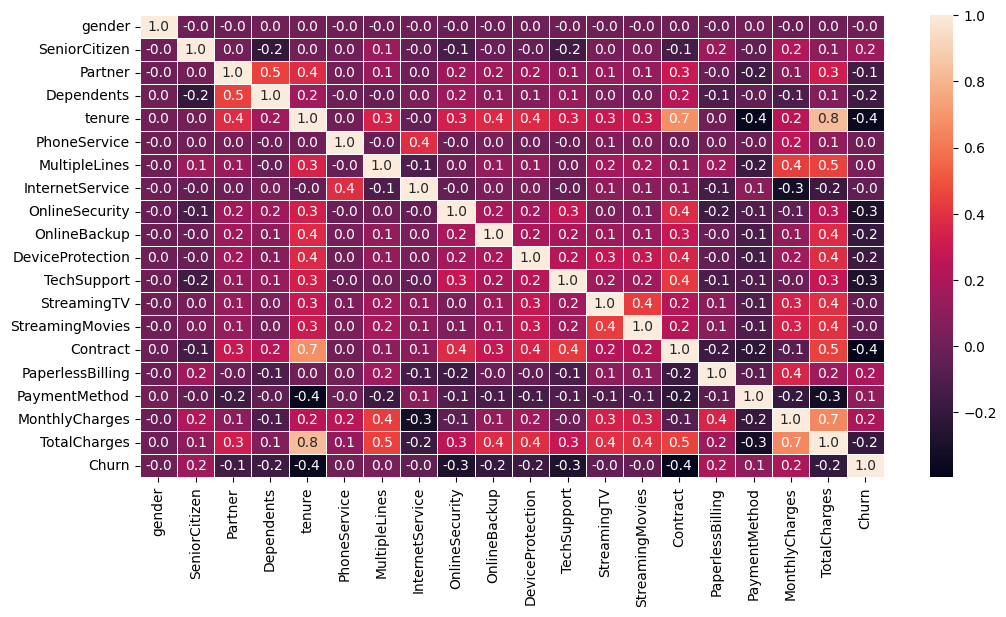

In [29]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.heatmap(df.corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax);

Выберем признаки, корреляция Пирсона для которых превышает 0.6

In [30]:
stacked = df.corr().stack()

In [31]:
stacked[((stacked > 0.6) | (stacked < -0.6)) & (stacked != 1)]

tenure          Contract          0.676734
                TotalCharges      0.825880
Contract        tenure            0.676734
MonthlyCharges  TotalCharges      0.651065
TotalCharges    tenure            0.825880
                MonthlyCharges    0.651065
dtype: float64

Визуализируем парные зависимости выбранных признаков

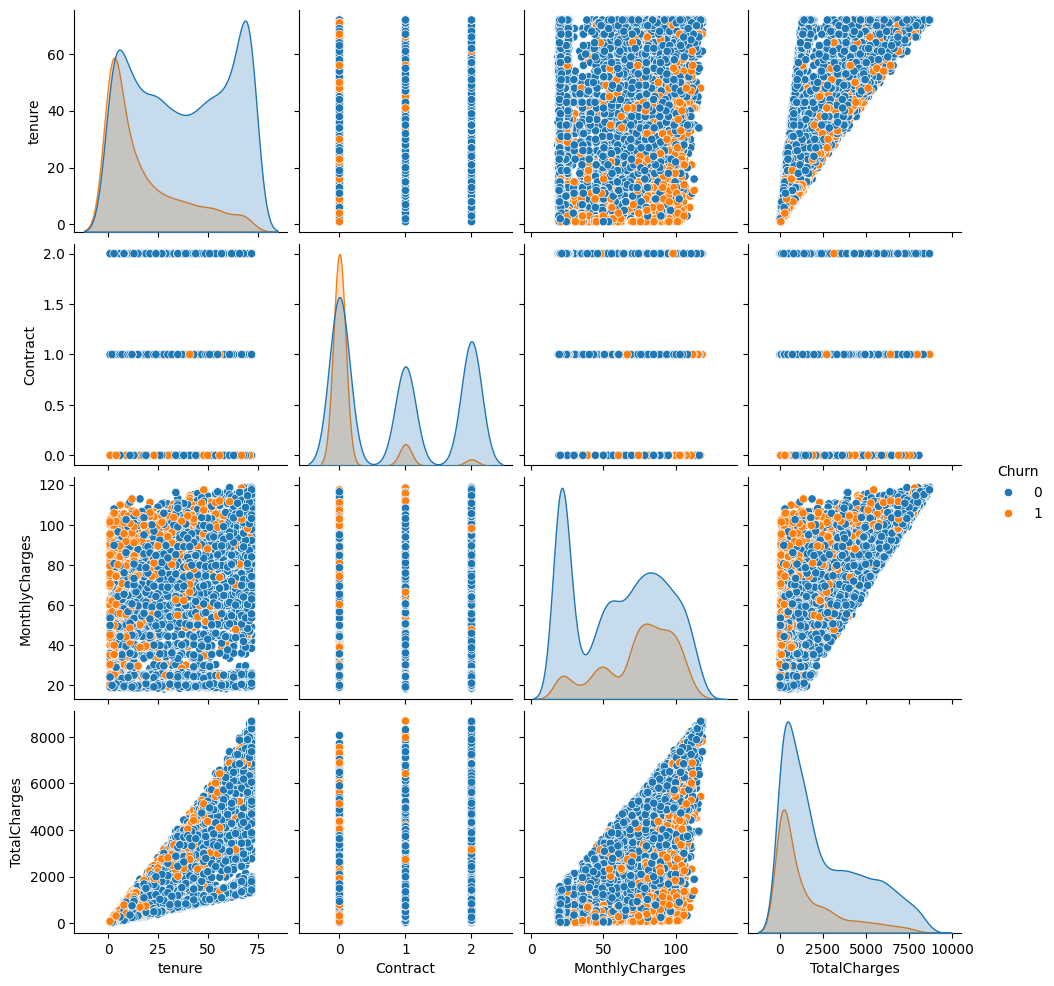

In [32]:
sns.pairplot(data=df[['tenure','Contract','MonthlyCharges','TotalCharges','Churn']], hue='Churn')
plt.show;

Зависимость есть, но нелинейная, поэтому, не будем удалять атрибуты из набора данных

### Correlation of Churn with other variables:

<Axes: >

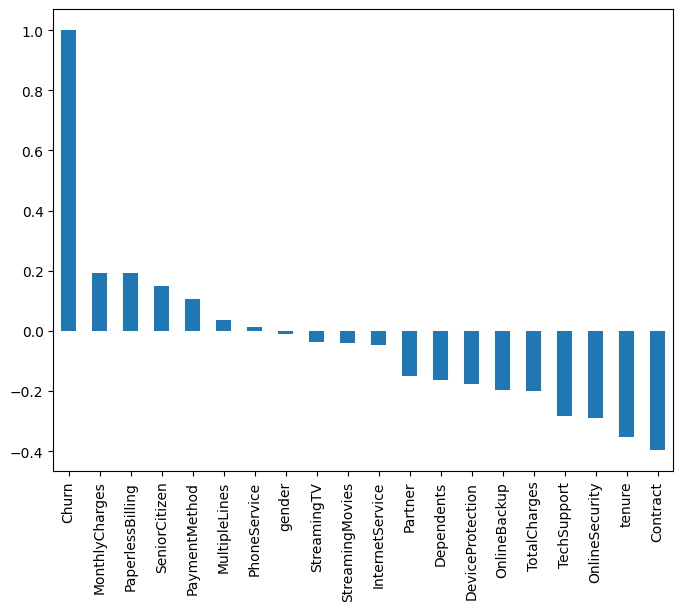

In [33]:
plt.figure(figsize=(8,6))
df.corr()['Churn'].sort_values(ascending = False).plot(kind='bar')

### Numerical Features vs Target Variable (Churn)

Посмотрим на распределение числовых признаков

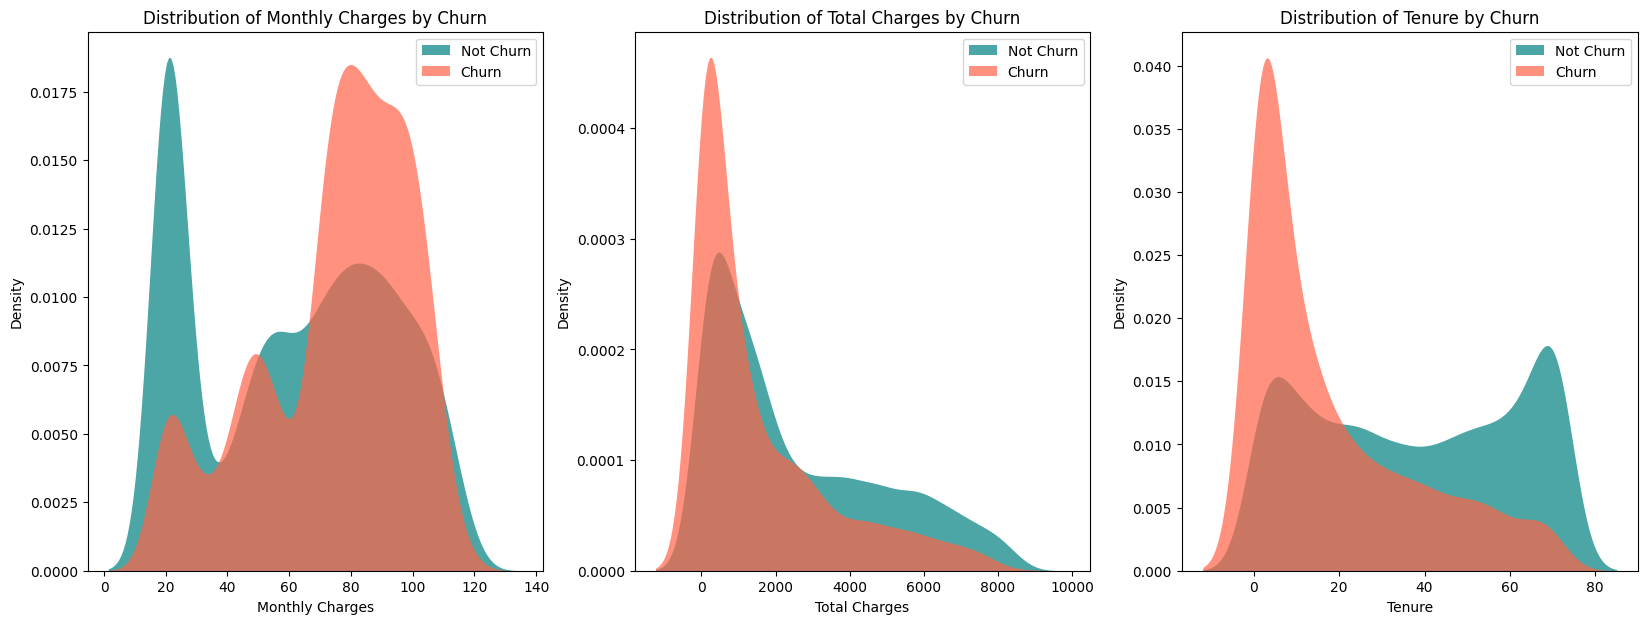

In [34]:
fig = plt.subplots(nrows = 1,ncols = 3,figsize = (20,7))

plt.subplot(1,3,1)
ax = sns.kdeplot(df.MonthlyCharges[(df["Churn"] == 0)], color='#008080', fill= True, alpha=.7, linewidth=0)
ax = sns.kdeplot(df.MonthlyCharges[(df["Churn"] == 1)], color='#FF6347', fill= True, alpha=.7, linewidth=0)
ax.legend(["Not Churn","Churn"],loc='upper right')
ax.set_ylabel('Density')
ax.set_xlabel('Monthly Charges')
ax.set_title('Distribution of Monthly Charges by Churn')

plt.subplot(1,3,2)
ax = sns.kdeplot(df.TotalCharges[(df["Churn"] == 0)], color='#008080', fill= True, alpha=.7, linewidth=0)
ax = sns.kdeplot(df.TotalCharges[(df["Churn"] == 1)], color='#FF6347', fill= True, alpha=.7, linewidth=0)
ax.legend(["Not Churn","Churn"],loc='upper right')
ax.set_ylabel('Density')
ax.set_xlabel('Total Charges')
ax.set_title('Distribution of Total Charges by Churn')

plt.subplot(1,3,3)
ax = sns.kdeplot(df.tenure[(df["Churn"] == 0)], color='#008080', fill= True, alpha=.7, linewidth=0)
ax = sns.kdeplot(df.tenure[(df["Churn"] == 1)], color='#FF6347', fill= True, alpha=.7, linewidth=0)
ax.legend(["Not Churn","Churn"],loc='upper right')
ax.set_ylabel('Density')
ax.set_xlabel('Tenure')
ax.set_title('Distribution of Tenure by Churn')

plt.show()

И также посмотрим на распределение целевой переменной

In [35]:
#Defining colors for the plots
palette = ['#008080','#FF6347', '#E50000', '#D2691E']

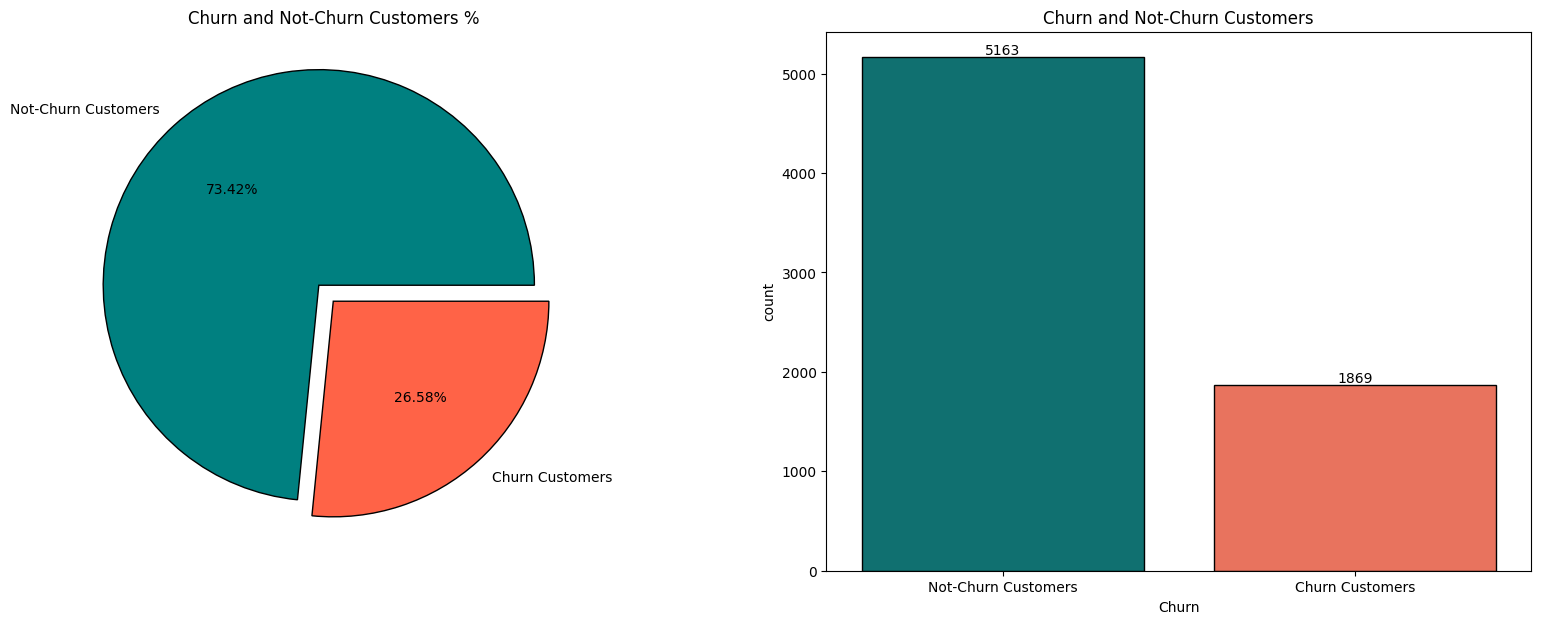

In [36]:
l1 = list(df['Churn'].value_counts())
pie_values = [l1[0] / sum(l1) * 100, l1[1] / sum(l1) * 100]

fig = plt.subplots(nrows = 1,ncols = 2,figsize = (20,7))

plt.subplot(1,2,1)
plt.pie(pie_values,labels = ['Not-Churn Customers','Churn Customers'], 
        autopct = '%1.2f%%',
        explode = (0.1,0),
        colors = palette,
        wedgeprops = {'edgecolor': 'black','linewidth': 1, 'antialiased' : True})
plt.title('Churn and Not-Churn Customers %');

plt.subplot(1,2,2)
ax = sns.countplot(data = df, 
                   x='Churn',
                   palette = palette, 
                   edgecolor = 'black')
for i in ax.containers:
    ax.bar_label(i,)
ax.set_xticklabels(['Not-Churn Customers','Churn Customers'])
    
plt.title('Churn and Not-Churn Customers')
plt.show()

Значение целевой переменной несбалансировано с соотношением ~ 1:4 - необходимо использовать параметр stratify при разделении набора данных на обучающую и тестовую выборки

# Splitting & Scaling

### Train test split - stratified splitting

In [37]:
X = df.drop('Churn', axis=1)
y = df['Churn']

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size = 0.3, random_state = 13)

### Feature scaling

In [39]:
numeric_columns = ['tenure', 'MonthlyCharges', 'TotalCharges']

In [40]:
std_scaler = StandardScaler()

In [41]:
X_train[numeric_columns] = std_scaler.fit_transform(X_train[numeric_columns])

In [42]:
X_test[numeric_columns]= std_scaler.transform(X_test[numeric_columns])

# Sklearn

Defining a function to evalute quality metrics

In [43]:
def quality(true_y, prediction_y):
    """
    Evaluates and returns the following metrics: Accuracy, Precision, Recall, F1-score, AUC
    """
    accuracy = round(accuracy_score(true_y, prediction_y), 3)
    precision = round(precision_score(true_y, prediction_y), 3)
    recall = round(recall_score(true_y, prediction_y), 3)
    f1 = round(f1_score(true_y, prediction_y), 3)
    auc = round(roc_auc_score(true_y, prediction_y), 3)
    print(f" Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"   Recall: {recall}")
    print(f" F1-score: {f1}")
    print(f"      AUC: {auc}")
    return [accuracy, precision, recall, f1, auc]

In [44]:
results = {}

In [45]:
# first run with default parameters
sgb_clf = GradientBoostingClassifier(random_state=13)

In [46]:
sgb_clf.fit(X_train, y_train)

GradientBoostingClassifier(random_state=13)

In [47]:
y_pred = sgb_clf.predict(X_test)

In [48]:
results['Sklearn'] = quality(y_test, y_pred)

 Accuracy: 0.807
Precision: 0.678
   Recall: 0.522
 F1-score: 0.59
      AUC: 0.716


In [49]:
pd.DataFrame(results, index = ['Accuracy', 'Precision', 'Recall', 'F1-score', 'AUC']).T

,Accuracy,Precision,Recall,F1-score,AUC
Sklearn,0.807,0.678,0.522,0.59,0.716


## Feature Importance

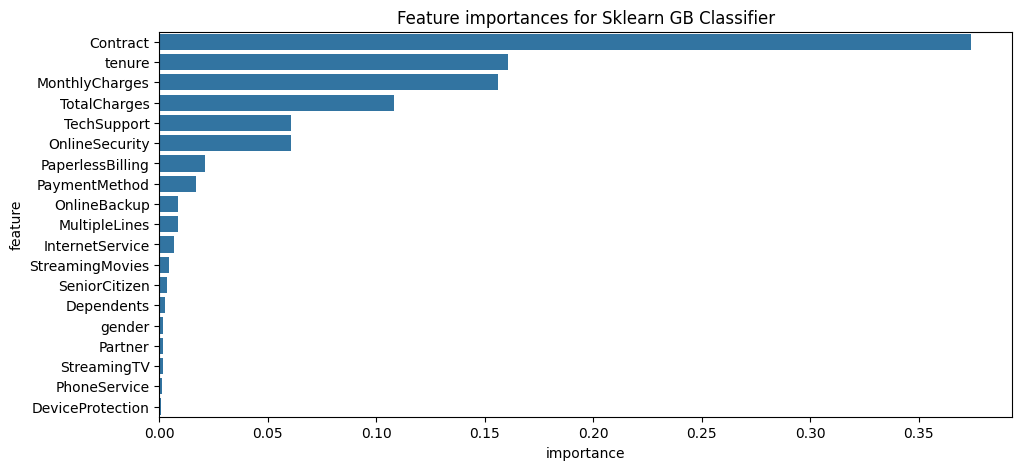

In [50]:
feature_importances = zip(X_train.columns, sgb_clf.feature_importances_)
feature_importances = sorted(feature_importances, key=lambda x: x[1], reverse=True)
feature_importances = pd.DataFrame(feature_importances, columns=['feature', 'importance'])

plt.figure(figsize=(11,5))
plt.title('Feature importances for Sklearn GB Classifier')
sns.barplot(x='importance', y='feature', data=feature_importances)
plt.show()

## Sklearn GB Number of Trees Validation Curve

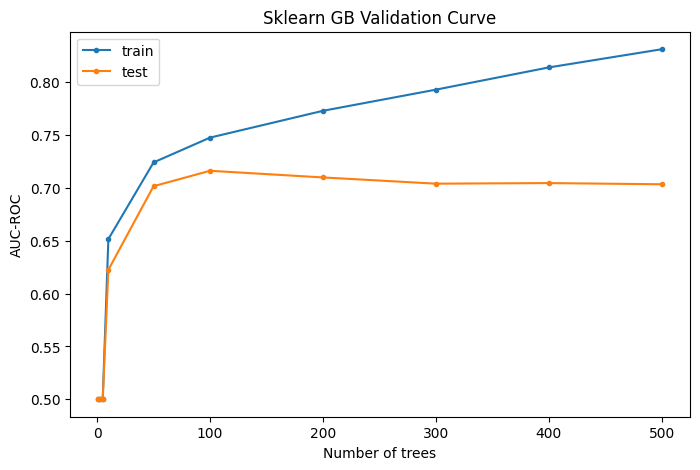

In [51]:
n_trees = [1, 3, 5, 10, 50, 100, 200, 300, 400, 500]
quals_train = []
quals_test = []
for n in n_trees:
    clf = GradientBoostingClassifier(n_estimators=n, random_state=13)
    clf.fit(X_train, y_train)
    q_train = roc_auc_score(y_train, clf.predict(X_train))
    q_test = roc_auc_score(y_test, clf.predict(X_test))

    quals_train.append(q_train)
    quals_test.append(q_test)

plt.figure(figsize=(8, 5))
plt.plot(n_trees, quals_train, marker='.', label='train')
plt.plot(n_trees, quals_test, marker='.', label='test')
plt.xlabel('Number of trees')
plt.ylabel('AUC-ROC')
plt.title('Sklearn GB Validation Curve')
plt.legend()

plt.show()

In [52]:
sorted(list(zip(quals_test, n_trees)), reverse=True)

[(0.7162731634117349, 100),
 (0.7099715876725712, 200),
 (0.7046383786215936, 400),
 (0.7040699019205077, 300),
 (0.7035014252194217, 500),
 (0.7016757404293955, 50),
 (0.6225124828967916, 10),
 (0.5, 5),
 (0.5, 3),
 (0.5, 1)]

Лучшая метрика достигается на 100 деревьях

Посмотрим, как влияет параметр learning_rate на качество алгоритма и склонность к переобучению

## Sklearn GB Learning Rate Validation Curve

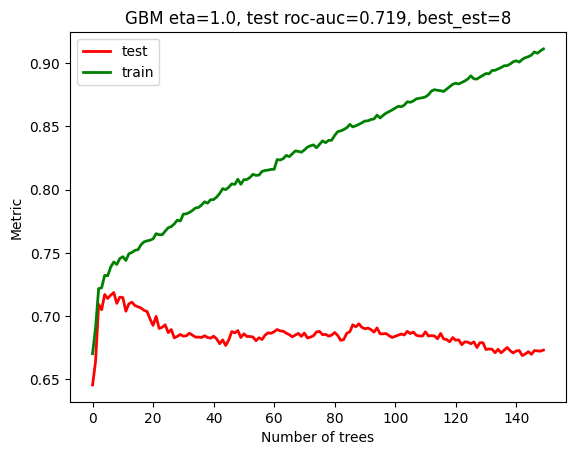

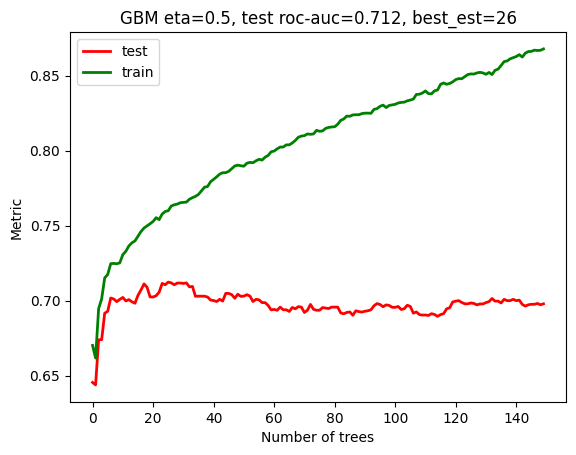

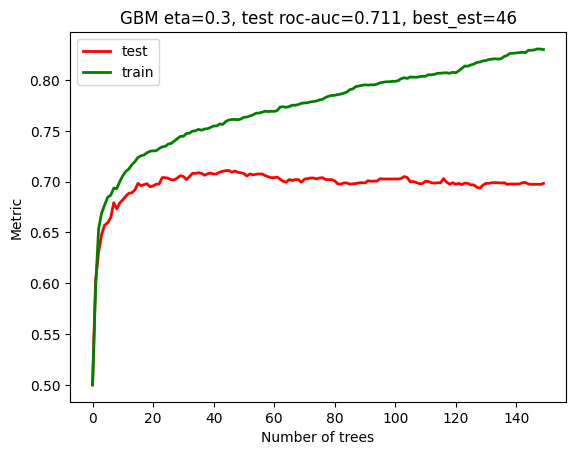

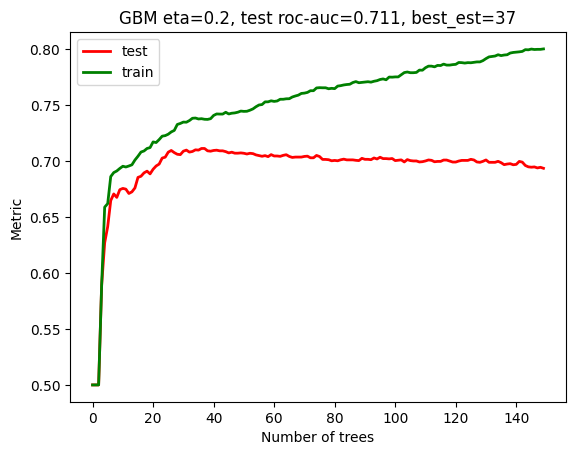

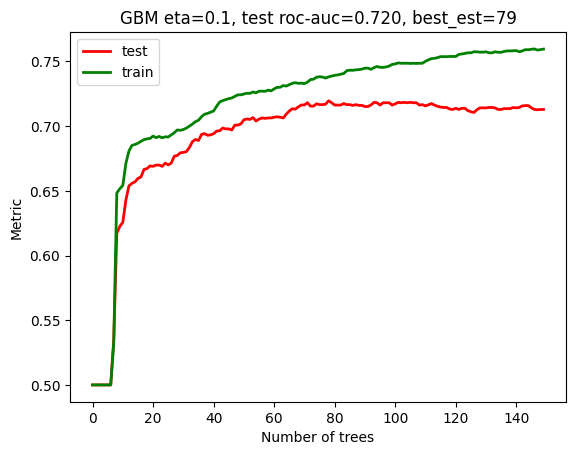

In [53]:
for learning_rate in [1, 0.5, 0.3, 0.2, 0.1]:

    gbm = GradientBoostingClassifier(n_estimators=150, learning_rate=learning_rate, random_state=13).fit(X_train, y_train)
    
    test_deviance = np.zeros((gbm.n_estimators,), dtype=np.float64)
    for i, y_pred in enumerate(gbm.staged_predict(X_test)):
        test_deviance[i] = roc_auc_score(y_test, y_pred)
    
    train_deviance = np.zeros((gbm.n_estimators,), dtype=np.float64)
    for i, y_pred in enumerate(gbm.staged_predict(X_train)):
        train_deviance[i] = roc_auc_score(y_train, y_pred)

    plt.figure()
    plt.plot(test_deviance, 'r', linewidth=2)
    plt.plot(train_deviance, 'g', linewidth=2)
    plt.legend(['test', 'train'])
    
    plt.title('GBM eta=%.1f, test roc-auc=%.3f, best_est=%d' % (learning_rate, test_deviance.max(), test_deviance.argmax()+1))
    plt.xlabel('Number of trees')
    plt.ylabel('Metric')

Запустим Sklearn GB с лучшими параметрами lr=0.1, n_estimators=79

In [54]:
sgb_clf = GradientBoostingClassifier(n_estimators=79, learning_rate=0.1, random_state=13)

In [55]:
sgb_clf.fit(X_train, y_train)

GradientBoostingClassifier(n_estimators=79, random_state=13)

In [56]:
y_pred = sgb_clf.predict(X_test)

In [57]:
results['Sklearn-VC'] = quality(y_test, y_pred)

 Accuracy: 0.809
Precision: 0.684
   Recall: 0.528
 F1-score: 0.596
      AUC: 0.72


In [58]:
pd.DataFrame(results, index = ['Accuracy', 'Precision', 'Recall', 'F1-score', 'AUC']).T

,Accuracy,Precision,Recall,F1-score,AUC
Sklearn,0.807,0.678,0.522,0.590,0.716
Sklearn-VC,0.809,0.684,0.528,0.596,0.720


## Sklearn GB GridSearch

In [59]:
# Define Gradient Boosting classifier with default parameters
clf = GradientBoostingClassifier(random_state=13)

# Estimate grid of the classifier hyperparameters
parameters = {'n_estimators':[10,50,80,150],
              'max_depth':[1,2,3,5],
              'learning_rate':[1,0.5,0.3,0.2,0.1]
             }

# Define GridSearch parameters
gs = GridSearchCV(clf,                 # Classifier object to optimize
                  parameters,          # Grid of the hyperparameters
                  scoring='roc_auc',   # Classification quality metric to optimize
                  #cv=3                 # Number of folds in KFolds cross-validation (CV)
                 )

# Run Grid Search optimization
gs.fit(X_train, y_train)
gs.best_params_

{'learning_rate': 0.2, 'max_depth': 1, 'n_estimators': 150}

In [60]:
pred_gs = gs.predict(X_test)

In [61]:
results['Sklearn-GS'] = quality(y_test, pred_gs)

 Accuracy: 0.808
Precision: 0.681
   Recall: 0.522
 F1-score: 0.591
      AUC: 0.717


In [62]:
pd.DataFrame(results, index = ['Accuracy', 'Precision', 'Recall', 'F1-score', 'AUC']).T

,Accuracy,Precision,Recall,F1-score,AUC
Sklearn,0.807,0.678,0.522,0.590,0.716
Sklearn-VC,0.809,0.684,0.528,0.596,0.720
Sklearn-GS,0.808,0.681,0.522,0.591,0.717


# XGBoost

In [63]:
xgb_clf = XGBClassifier(random_state=13)

In [64]:
xgb_clf.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=13, ...)

In [65]:
y_pred = xgb_clf.predict(X_test)

In [66]:
results['XGBoost'] = quality(y_test, y_pred)

 Accuracy: 0.786
Precision: 0.621
   Recall: 0.503
 F1-score: 0.556
      AUC: 0.696


In [67]:
pd.DataFrame(results, index = ['Accuracy', 'Precision', 'Recall', 'F1-score', 'AUC']).T

,Accuracy,Precision,Recall,F1-score,AUC
Sklearn,0.807,0.678,0.522,0.590,0.716
Sklearn-VC,0.809,0.684,0.528,0.596,0.720
Sklearn-GS,0.808,0.681,0.522,0.591,0.717
XGBoost,0.786,0.621,0.503,0.556,0.696


## Feature importance

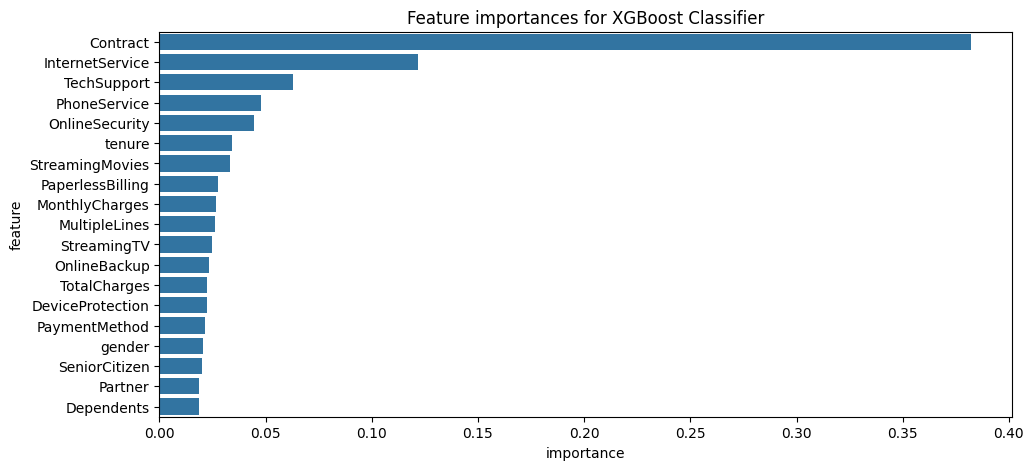

In [68]:
feature_importances = zip(X_train.columns, xgb_clf.feature_importances_)
feature_importances = sorted(feature_importances, key=lambda x: x[1], reverse=True)
feature_importances = pd.DataFrame(feature_importances, columns=['feature', 'importance'])

plt.figure(figsize=(11,5))
plt.title('Feature importances for XGBoost Classifier')
sns.barplot(x='importance', y='feature', data=feature_importances)
plt.show()

## XGBoost Validation Curve

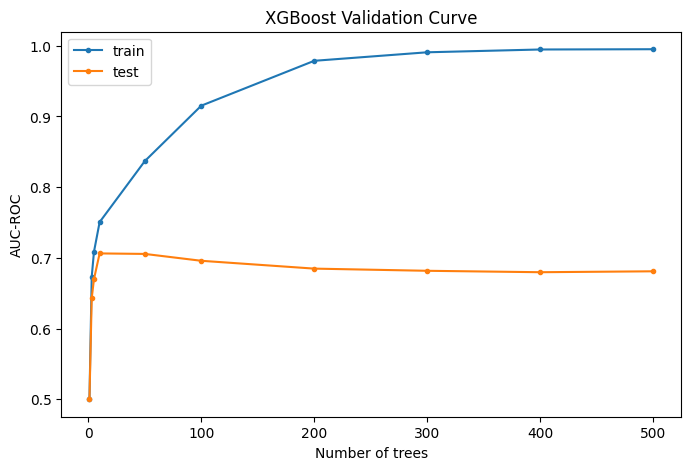

In [69]:
n_trees = [1, 3, 5, 10, 50, 100, 200, 300, 400, 500]
quals_train = []
quals_test = []
for n in n_trees:
    clf = XGBClassifier(n_estimators=n, random_state=13)
    clf.fit(X_train, y_train)
    q_train = roc_auc_score(y_train, clf.predict(X_train))
    q_test = roc_auc_score(y_test, clf.predict(X_test))

    quals_train.append(q_train)
    quals_test.append(q_test)

plt.figure(figsize=(8, 5))
plt.plot(n_trees, quals_train, marker='.', label='train')
plt.plot(n_trees, quals_test, marker='.', label='test')
plt.xlabel('Number of trees')
plt.ylabel('AUC-ROC')
plt.title('XGBoost Validation Curve')
plt.legend()

plt.show()

In [70]:
sorted(list(zip(quals_test, n_trees)), reverse=True)

[(0.7062379385699934, 10),
 (0.7055296442187416, 50),
 (0.6958172082730621, 100),
 (0.6847365156520968, 200),
 (0.6816628288735529, 300),
 (0.6809401499903911, 500),
 (0.6796489944061432, 400),
 (0.6699756843872593, 5),
 (0.6428717739810286, 3),
 (0.5, 1)]

Лучший результат получаем для 10 деревьев

Посмотрим, как влияет параметр learning_rate на качество алгоритма и склонность к переобучению.

## XGBoost Learning Rate Validation Curve

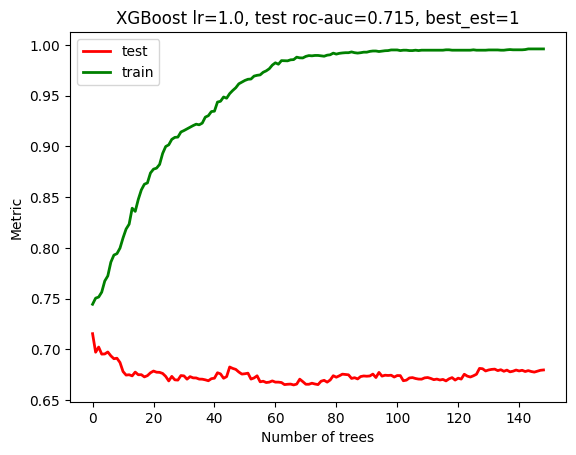

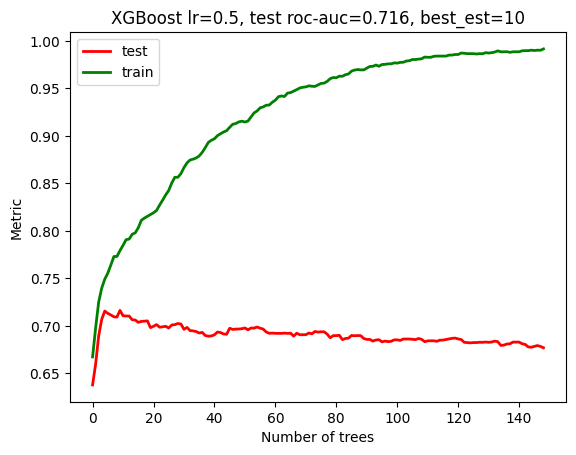

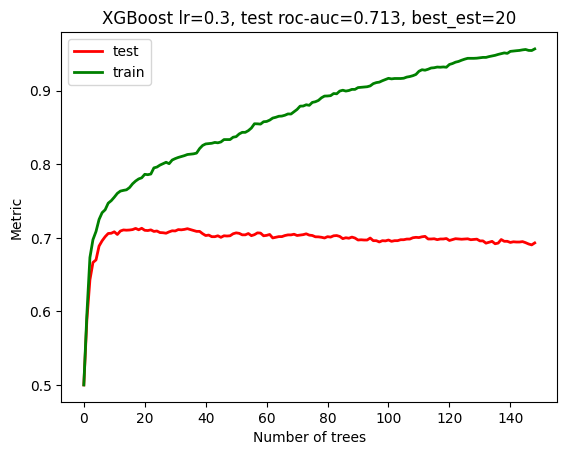

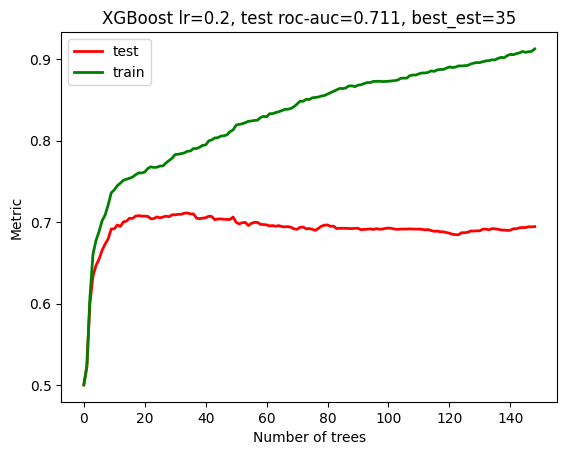

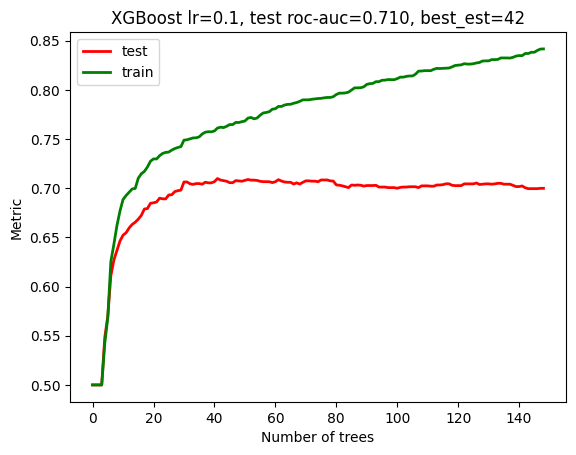

In [71]:
for learning_rate in [1, 0.5, 0.3, 0.2, 0.1]:

    xgb = XGBClassifier(n_estimators=150, learning_rate=learning_rate, random_state=13, verbose=-1).fit(X_train, y_train)

    test_deviance = np.zeros((xgb.n_estimators,), dtype=np.float64)
    for i in range(xgb.n_estimators):
        y_pred_test = xgb.predict(X_test, iteration_range=(0,i))
        test_deviance[i] = roc_auc_score(y_test, y_pred_test)

    train_deviance = np.zeros((xgb.n_estimators,), dtype=np.float64)
    for i in range(xgb.n_estimators):
        y_pred_train = xgb.predict(X_train, iteration_range=(0,i))
        train_deviance[i] = roc_auc_score(y_train, y_pred_train)

    plt.figure()
    plt.plot(test_deviance[1:], 'r', linewidth=2)
    plt.plot(train_deviance[1:], 'g', linewidth=2)
    plt.legend(['test', 'train'])
    
    plt.title('XGBoost lr=%.1f, test roc-auc=%.3f, best_est=%d' % (learning_rate, test_deviance.max(), test_deviance.argmax()))
    plt.xlabel('Number of trees')
    plt.ylabel('Metric')

Запустим модель с оптимальными параметрами lr=0.5, n_estimators=10

In [72]:
xgb_clf = XGBClassifier(n_estimators=10, learning_rate=0.5, random_state=13)
xgb_clf.fit(X_train, y_train)
y_pred = xgb_clf.predict(X_test)

In [73]:
results['XGBoost-VC'] = quality(y_test, y_pred)

 Accuracy: 0.803
Precision: 0.661
   Recall: 0.531
 F1-score: 0.589
      AUC: 0.716


In [74]:
pd.DataFrame(results, index = ['Accuracy', 'Precision', 'Recall', 'F1-score', 'AUC']).T

,Accuracy,Precision,Recall,F1-score,AUC
Sklearn,0.807,0.678,0.522,0.590,0.716
Sklearn-VC,0.809,0.684,0.528,0.596,0.720
Sklearn-GS,0.808,0.681,0.522,0.591,0.717
XGBoost,0.786,0.621,0.503,0.556,0.696
XGBoost-VC,0.803,0.661,0.531,0.589,0.716


## XGBoost GridSearch

In [75]:
# Define Gradient Boosting classifier with default parameters
clf = XGBClassifier(random_state=13)

# Estimate grid of the classifier hyperparameters
parameters = {'n_estimators':[10,50,100],
              'max_depth':[1,2,3,5],
              'learning_rate':[1,0.5,0.3]
             }

# Define GridSearch parameters
gs = GridSearchCV(clf,                 # Classifier object to optimize
                  parameters,          # Grid of the hyperparameters
                  scoring='roc_auc',   # Classification quality metric to optimize
                  #cv=3                 # Number of folds in KFolds cross-validation (CV)
                 )

# Run Grid Search optimization
gs.fit(X_train, y_train)
gs.best_params_

{'learning_rate': 0.5, 'max_depth': 1, 'n_estimators': 50}

In [76]:
pred_gs = gs.predict(X_test)

In [77]:
results['XGBoost-GS'] = quality(y_test, pred_gs)

 Accuracy: 0.806
Precision: 0.668
   Recall: 0.535
 F1-score: 0.594
      AUC: 0.719


In [78]:
pd.DataFrame(results, index = ['Accuracy', 'Precision', 'Recall', 'F1-score', 'AUC']).T

,Accuracy,Precision,Recall,F1-score,AUC
Sklearn,0.807,0.678,0.522,0.590,0.716
Sklearn-VC,0.809,0.684,0.528,0.596,0.720
Sklearn-GS,0.808,0.681,0.522,0.591,0.717
XGBoost,0.786,0.621,0.503,0.556,0.696
XGBoost-VC,0.803,0.661,0.531,0.589,0.716
XGBoost-GS,0.806,0.668,0.535,0.594,0.719


# LightGBM

In [79]:
lgbm_clf = LGBMClassifier(verbose=-1, random_state=13)

In [80]:
lgbm_clf.fit(X_train, y_train)

LGBMClassifier(random_state=13, verbose=-1)

In [81]:
y_pred = lgbm_clf.predict(X_test)

In [82]:
results['LightGBM'] = quality(y_test, y_pred)

 Accuracy: 0.794
Precision: 0.643
   Recall: 0.504
 F1-score: 0.565
      AUC: 0.702


In [83]:
pd.DataFrame(results, index = ['Accuracy', 'Precision', 'Recall', 'F1-score', 'AUC']).T

,Accuracy,Precision,Recall,F1-score,AUC
Sklearn,0.807,0.678,0.522,0.590,0.716
Sklearn-VC,0.809,0.684,0.528,0.596,0.720
Sklearn-GS,0.808,0.681,0.522,0.591,0.717
XGBoost,0.786,0.621,0.503,0.556,0.696
XGBoost-VC,0.803,0.661,0.531,0.589,0.716
XGBoost-GS,0.806,0.668,0.535,0.594,0.719
LightGBM,0.794,0.643,0.504,0.565,0.702


## Feature importance

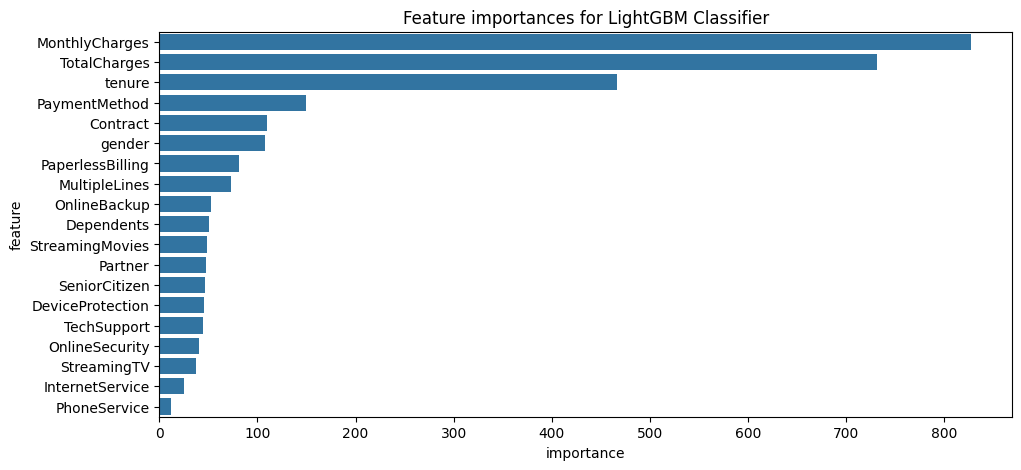

In [84]:
feature_importances = zip(X_train.columns, lgbm_clf.feature_importances_)
feature_importances = sorted(feature_importances, key=lambda x: x[1], reverse=True)
feature_importances = pd.DataFrame(feature_importances, columns=['feature', 'importance'])

plt.figure(figsize=(11,5))
plt.title('Feature importances for LightGBM Classifier')
sns.barplot(x='importance', y='feature', data=feature_importances)
plt.show()

## LightGBM Number of Trees Validation Curve

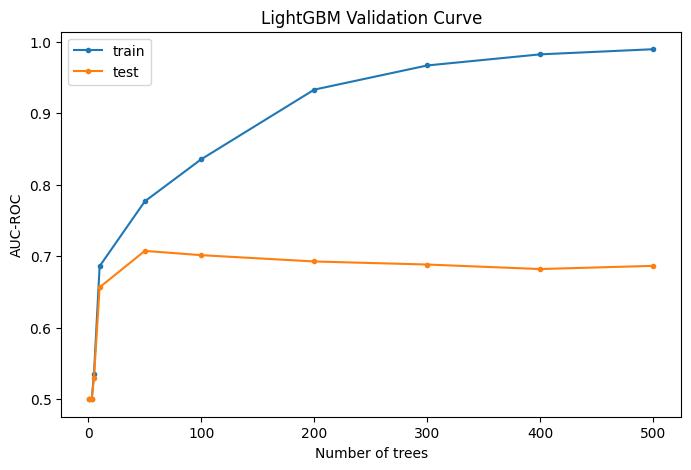

In [85]:
n_trees = [1, 3, 5, 10, 50, 100, 200, 300, 400, 500]
quals_train = []
quals_test = []
for n in n_trees:
    clf = LGBMClassifier(n_estimators=n, verbose=-1, random_state=13)
    clf.fit(X_train, y_train)
    q_train = roc_auc_score(y_train, clf.predict(X_train))
    q_test = roc_auc_score(y_test, clf.predict(X_test))

    quals_train.append(q_train)
    quals_test.append(q_test)

plt.figure(figsize=(8, 5))
plt.plot(n_trees, quals_train, marker='.', label='train')
plt.plot(n_trees, quals_test, marker='.', label='test')
plt.xlabel('Number of trees')
plt.ylabel('AUC-ROC')
plt.title('LightGBM Validation Curve')
plt.legend()

plt.show()

In [86]:
sorted(list(zip(quals_test, n_trees)), reverse=True)

[(0.7075290941542413, 50),
 (0.7015503073111397, 100),
 (0.6927435214945183, 200),
 (0.6884557802227645, 300),
 (0.6865961479374308, 500),
 (0.682139819951691, 400),
 (0.6565635468343097, 10),
 (0.5301488281209544, 5),
 (0.5, 3),
 (0.5, 1)]

Лучший результат достигается для 50

Посмотрим, как влияет параметр learning_rate на качество алгоритма и склонность к переобучению.

## LightGBM Learning Rate Validation curve

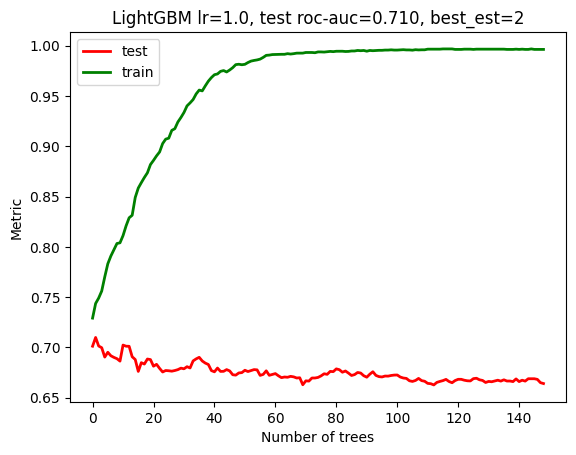

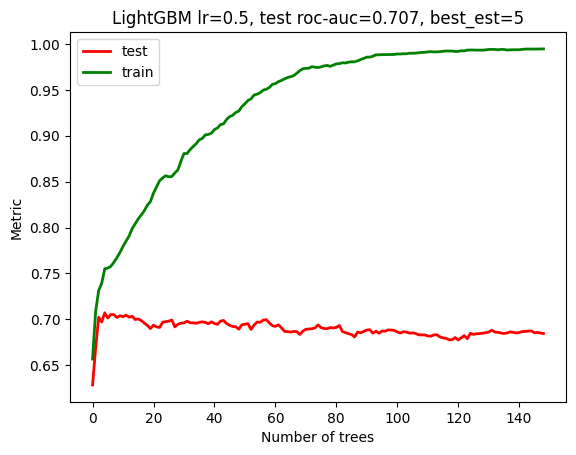

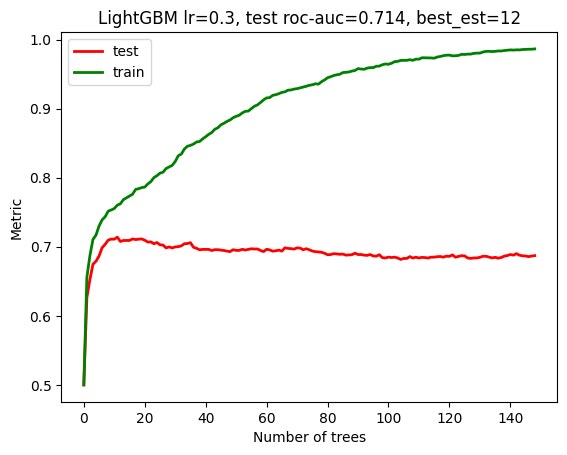

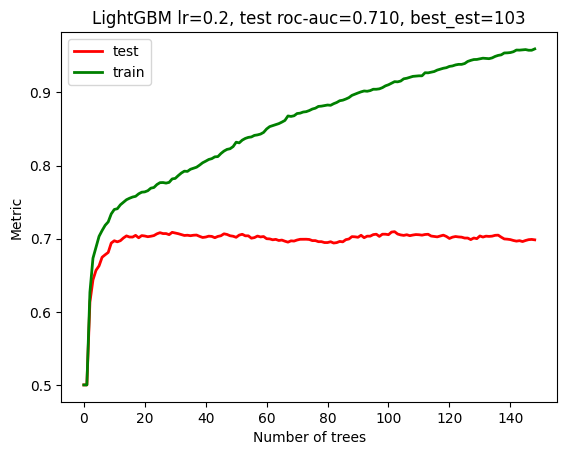

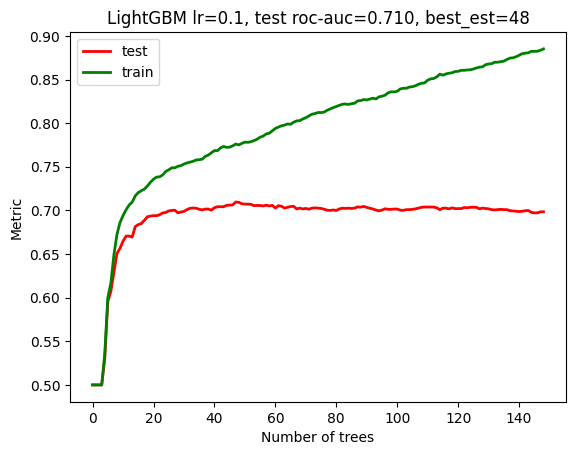

In [87]:
for learning_rate in [1, 0.5, 0.3, 0.2, 0.1]:

    lgb = LGBMClassifier(n_estimators=150, learning_rate=learning_rate, random_state=13, verbose=-1).fit(X_train, y_train)

    test_deviance = np.zeros((lgb.n_estimators,), dtype=np.float64)
    for i in range(lgb.n_estimators):
        y_pred_test = lgb.predict(X_test, num_iteration=i)
        test_deviance[i] = roc_auc_score(y_test, y_pred_test)

    train_deviance = np.zeros((lgb.n_estimators,), dtype=np.float64)
    for i in range(lgb.n_estimators):
        y_pred_train = lgb.predict(X_train, num_iteration=i)
        train_deviance[i] = roc_auc_score(y_train, y_pred_train)

    plt.figure()
    plt.plot(test_deviance[1:], 'r', linewidth=2)
    plt.plot(train_deviance[1:], 'g', linewidth=2)
    plt.legend(['test', 'train'])
    
    plt.title('LightGBM lr=%.1f, test roc-auc=%.3f, best_est=%d' % (learning_rate, test_deviance.max(), test_deviance.argmax()))
    plt.xlabel('Number of trees')
    plt.ylabel('Metric')

Запустим модель с лучшим набором параметров lr=0.3, n_estimators=12

In [88]:
lgbm = LGBMClassifier(n_estimators=12, learning_rate=0.3, verbose=-1, random_state=13)
lgbm.fit(X_train, y_train)
y_pred = lgbm.predict(X_test)

In [89]:
results['LightGBM-VC'] = quality(y_test, y_pred)

 Accuracy: 0.803
Precision: 0.664
   Recall: 0.524
 F1-score: 0.586
      AUC: 0.714


In [90]:
pd.DataFrame(results, index = ['Accuracy', 'Precision', 'Recall', 'F1-score', 'AUC']).T

,Accuracy,Precision,Recall,F1-score,AUC
Sklearn,0.807,0.678,0.522,0.590,0.716
Sklearn-VC,0.809,0.684,0.528,0.596,0.720
Sklearn-GS,0.808,0.681,0.522,0.591,0.717
XGBoost,0.786,0.621,0.503,0.556,0.696
XGBoost-VC,0.803,0.661,0.531,0.589,0.716
XGBoost-GS,0.806,0.668,0.535,0.594,0.719
LightGBM,0.794,0.643,0.504,0.565,0.702
LightGBM-VC,0.803,0.664,0.524,0.586,0.714


## LightGBM GridSearch

In [91]:
# Define Gradient Boosting classifier with default parameters
clf = LGBMClassifier(verbose=-1, random_state=13)

# Estimate grid of the classifier hyperparameters
parameters = {'n_estimators':[10,50,100,150],
              'max_depth':[1,2,3,5],
              'learning_rate':[1,0.5,0.3,0.2,0.1]
             }

# Define GridSearch parameters
gs = GridSearchCV(clf,                 # Classifier object to optimize
                  parameters,          # Grid of the hyperparameters
                  scoring='roc_auc',   # Classification quality metric to optimize
                  #cv=3                 # Number of folds in KFolds cross-validation (CV)
                 )

# Run Grid Search optimization
gs.fit(X_train, y_train)
gs.best_params_

{'learning_rate': 0.2, 'max_depth': 1, 'n_estimators': 150}

In [92]:
pred_gs = gs.predict(X_test)

In [93]:
results['LightGBM-GS'] = quality(y_test, pred_gs)

 Accuracy: 0.806
Precision: 0.669
   Recall: 0.533
 F1-score: 0.593
      AUC: 0.719


In [94]:
pd.DataFrame(results, index = ['Accuracy', 'Precision', 'Recall', 'F1-score', 'AUC']).T

,Accuracy,Precision,Recall,F1-score,AUC
Sklearn,0.807,0.678,0.522,0.590,0.716
Sklearn-VC,0.809,0.684,0.528,0.596,0.720
Sklearn-GS,0.808,0.681,0.522,0.591,0.717
XGBoost,0.786,0.621,0.503,0.556,0.696
XGBoost-VC,0.803,0.661,0.531,0.589,0.716
XGBoost-GS,0.806,0.668,0.535,0.594,0.719
LightGBM,0.794,0.643,0.504,0.565,0.702
LightGBM-VC,0.803,0.664,0.524,0.586,0.714
LightGBM-GS,0.806,0.669,0.533,0.593,0.719


# CatBoost

In [95]:
catboost = CatBoostClassifier(logging_level='Silent', random_state=13)

In [96]:
catboost.fit(X_train, y_train)

In [97]:
pred = catboost.predict(X_test)

In [98]:
results['Catboost'] = quality(y_test, pred)

 Accuracy: 0.799
Precision: 0.656
   Recall: 0.51
 F1-score: 0.574
      AUC: 0.706


In [99]:
pd.DataFrame(results, index = ['Accuracy', 'Precision', 'Recall', 'F1-score', 'AUC']).T

,Accuracy,Precision,Recall,F1-score,AUC
Sklearn,0.807,0.678,0.522,0.590,0.716
Sklearn-VC,0.809,0.684,0.528,0.596,0.720
Sklearn-GS,0.808,0.681,0.522,0.591,0.717
XGBoost,0.786,0.621,0.503,0.556,0.696
XGBoost-VC,0.803,0.661,0.531,0.589,0.716
XGBoost-GS,0.806,0.668,0.535,0.594,0.719
LightGBM,0.794,0.643,0.504,0.565,0.702
LightGBM-VC,0.803,0.664,0.524,0.586,0.714
LightGBM-GS,0.806,0.669,0.533,0.593,0.719
Catboost,0.799,0.656,0.510,0.574,0.706


## Feature importance

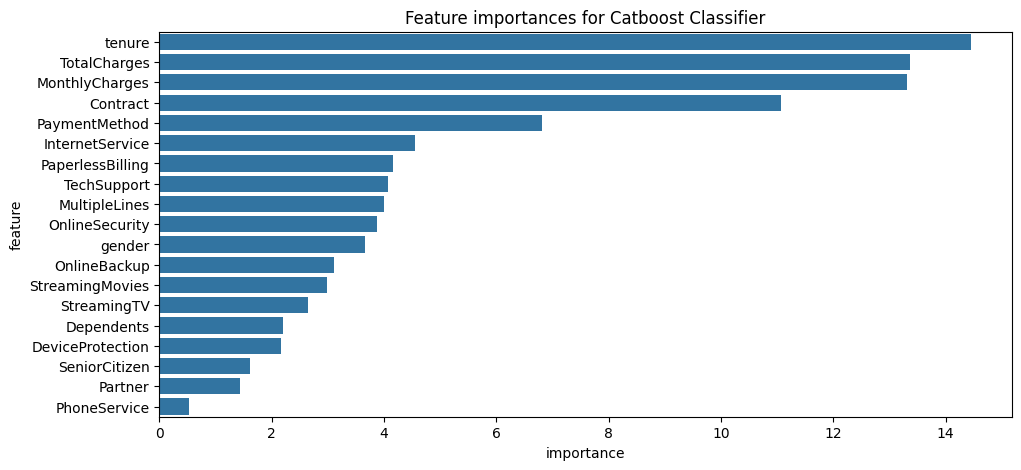

In [100]:
feature_importances = zip(X_train.columns, catboost.feature_importances_)
feature_importances = sorted(feature_importances, key=lambda x: x[1], reverse=True)
feature_importances = pd.DataFrame(feature_importances, columns=['feature', 'importance'])

plt.figure(figsize=(11,5))
plt.title('Feature importances for Catboost Classifier')
sns.barplot(x='importance', y='feature', data=feature_importances)
plt.show()

In [101]:
## Alternative visualisation using only matplotlib
#feature_importance = catboost.feature_importances_
#sorted_idx = np.argsort(feature_importance)
#fig = plt.figure(figsize=(12, 8))
#plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
#plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
#plt.title('Feature importance for Gradient Boosting (catboost)');

## Catboost Number of Trees Validation Curve

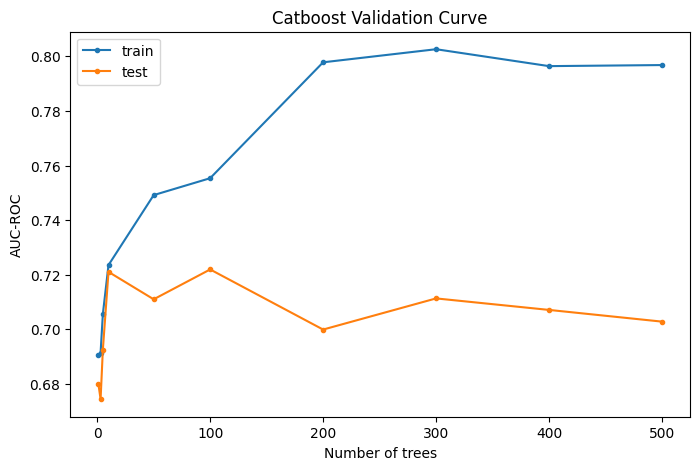

In [102]:
n_trees = [1, 3, 5, 10, 50, 100, 200, 300, 400, 500]
quals_train = []
quals_test = []
for n in n_trees:
    clf = CatBoostClassifier(iterations=n, logging_level='Silent', random_state=13)
    clf.fit(X_train, y_train)
    q_train = roc_auc_score(y_train, clf.predict(X_train))
    q_test = roc_auc_score(y_test, clf.predict(X_test))

    quals_train.append(q_train)
    quals_test.append(q_test)

plt.figure(figsize=(8, 5))
plt.plot(n_trees, quals_train, marker='.', label='train')
plt.plot(n_trees, quals_test, marker='.', label='test')
plt.xlabel('Number of trees')
plt.ylabel('AUC-ROC')
plt.title('Catboost Validation Curve')
plt.legend()

plt.show()

In [103]:
sorted(list(zip(quals_test, n_trees)), reverse=True)

[(0.7219435458906844, 100),
 (0.7210522802935365, 10),
 (0.7113398443478572, 300),
 (0.7110170554517953, 50),
 (0.7071292041671413, 400),
 (0.7028414628953876, 500),
 (0.6999363628308299, 200),
 (0.69259449774393, 5),
 (0.680159932979589, 1),
 (0.6744320123729989, 3)]

Лучший результат достигается для 100 деревьев

Посмотрим, как влияет параметр learning_rate на качество алгоритма и склонность к переобучению.

## Catboost Learning Rate Validation Curve

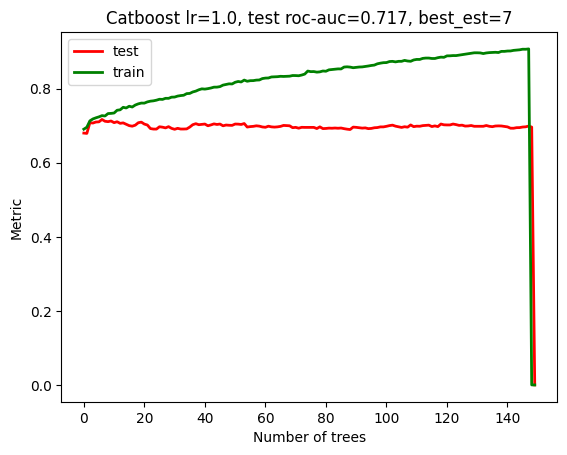

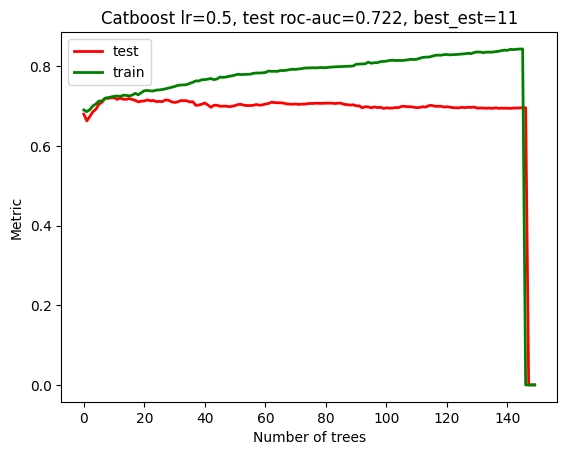

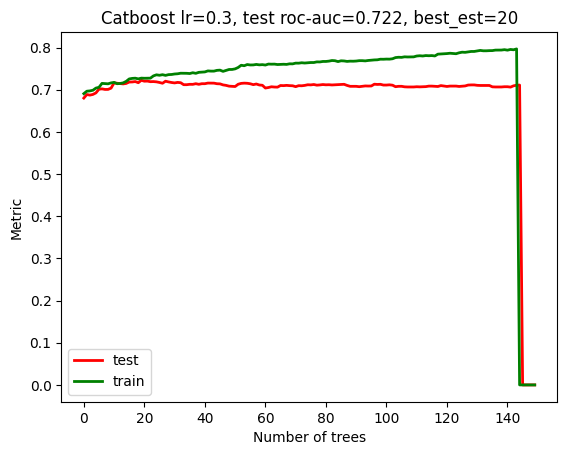

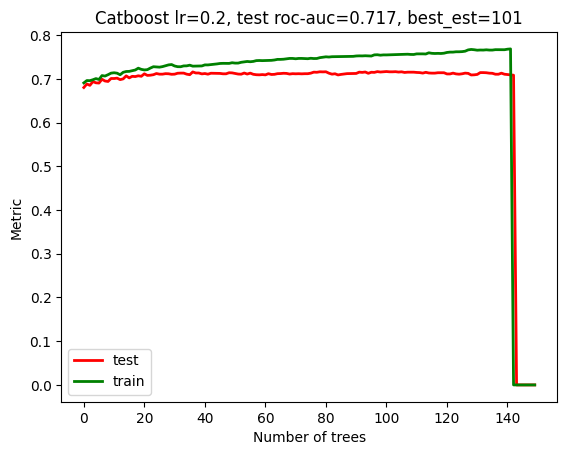

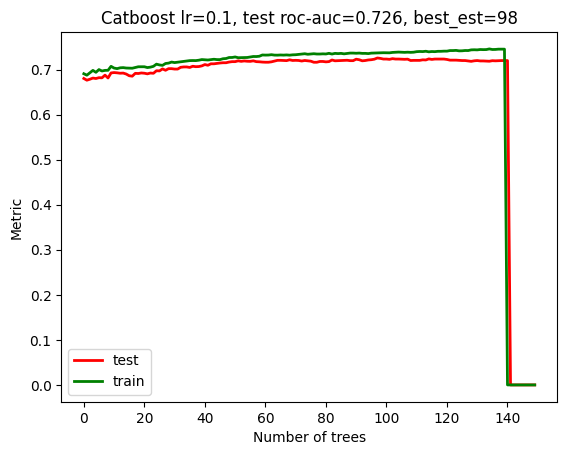

In [104]:
n_iterations = 150
for learning_rate in [1, 0.5, 0.3, 0.2, 0.1]:

    cbt = CatBoostClassifier(iterations=n_iterations, learning_rate=learning_rate, logging_level='Silent', random_state=13).fit(X_train, y_train)
    
    test_deviance = np.zeros((n_iterations,), dtype=np.float64)
    for i, y_pred in enumerate(cbt.staged_predict(X_test, prediction_type='Class', ntree_start=0, ntree_end=i)):
        test_deviance[i] = roc_auc_score(y_test, y_pred)
    
    train_deviance = np.zeros((n_iterations,), dtype=np.float64)
    for i, y_pred in enumerate(cbt.staged_predict(X_train, prediction_type='Class', ntree_start=0, ntree_end=i)):
        train_deviance[i] = roc_auc_score(y_train, y_pred)

    plt.figure()
    plt.plot(test_deviance, 'r', linewidth=2)
    plt.plot(train_deviance, 'g', linewidth=2)
    plt.legend(['test', 'train'])
    
    plt.title('Catboost lr=%.1f, test roc-auc=%.3f, best_est=%d' % (learning_rate, test_deviance.max(), test_deviance.argmax()+1))
    plt.xlabel('Number of trees')
    plt.ylabel('Metric')

Запустим модель с лучшим набором параметров lr=0.1, n_estimators=98

In [105]:
catboost = CatBoostClassifier(iterations=98, learning_rate=0.1, logging_level='Silent', random_state=13)
catboost.fit(X_train, y_train)
pred = catboost.predict(X_test)

In [106]:
results['Catboost-VC'] = quality(y_test, pred)

 Accuracy: 0.81
Precision: 0.677
   Recall: 0.545
 F1-score: 0.604
      AUC: 0.726


In [107]:
pd.DataFrame(results, index = ['Accuracy', 'Precision', 'Recall', 'F1-score', 'AUC']).T

,Accuracy,Precision,Recall,F1-score,AUC
Sklearn,0.807,0.678,0.522,0.590,0.716
Sklearn-VC,0.809,0.684,0.528,0.596,0.720
Sklearn-GS,0.808,0.681,0.522,0.591,0.717
XGBoost,0.786,0.621,0.503,0.556,0.696
XGBoost-VC,0.803,0.661,0.531,0.589,0.716
XGBoost-GS,0.806,0.668,0.535,0.594,0.719
LightGBM,0.794,0.643,0.504,0.565,0.702
LightGBM-VC,0.803,0.664,0.524,0.586,0.714
LightGBM-GS,0.806,0.669,0.533,0.593,0.719
Catboost,0.799,0.656,0.510,0.574,0.706


## Catboost GridSearch

In [108]:
# Define Gradient Boosting classifier with default parameters
clf = CatBoostClassifier(logging_level='Silent', random_state=13)

# Estimate grid of the classifier hyperparameters
parameters = {'n_estimators':[10,50,100,150],
              'max_depth':[1,2,3,5],
              'learning_rate':[1,0.5,0.3,0.2,0.1]
             }

# Define GridSearch parameters
gs = GridSearchCV(clf,                 # Classifier object to optimize
                  parameters,          # Grid of the hyperparameters
                  scoring='roc_auc',   # Classification quality metric to optimize
                  #cv=3                 # Number of folds in KFolds cross-validation (CV)
                 )

# Run Grid Search optimization
gs.fit(X_train, y_train)
gs.best_params_

{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}

In [109]:
pred_gs = gs.predict(X_test)

In [110]:
results['CatBoost-GS'] = quality(y_test, pred_gs)

 Accuracy: 0.808
Precision: 0.676
   Recall: 0.533
 F1-score: 0.596
      AUC: 0.72


In [111]:
pd.DataFrame(results, index = ['Accuracy', 'Precision', 'Recall', 'F1-score', 'AUC']).T

,Accuracy,Precision,Recall,F1-score,AUC
Sklearn,0.807,0.678,0.522,0.590,0.716
Sklearn-VC,0.809,0.684,0.528,0.596,0.720
Sklearn-GS,0.808,0.681,0.522,0.591,0.717
XGBoost,0.786,0.621,0.503,0.556,0.696
XGBoost-VC,0.803,0.661,0.531,0.589,0.716
XGBoost-GS,0.806,0.668,0.535,0.594,0.719
LightGBM,0.794,0.643,0.504,0.565,0.702
LightGBM-VC,0.803,0.664,0.524,0.586,0.714
LightGBM-GS,0.806,0.669,0.533,0.593,0.719
Catboost,0.799,0.656,0.510,0.574,0.706


## Summary

#### Итоговая таблица лидеров

In [112]:
pd.DataFrame(results, index = ['Accuracy', 'Precision', 'Recall', 'F1-score', 'AUC']).T.sort_values(by=['AUC'], ascending=False)

,Accuracy,Precision,Recall,F1-score,AUC
Catboost-VC,0.810,0.677,0.545,0.604,0.726
Sklearn-VC,0.809,0.684,0.528,0.596,0.720
CatBoost-GS,0.808,0.676,0.533,0.596,0.720
XGBoost-GS,0.806,0.668,0.535,0.594,0.719
LightGBM-GS,0.806,0.669,0.533,0.593,0.719
Sklearn-GS,0.808,0.681,0.522,0.591,0.717
Sklearn,0.807,0.678,0.522,0.590,0.716
XGBoost-VC,0.803,0.661,0.531,0.589,0.716
LightGBM-VC,0.803,0.664,0.524,0.586,0.714
Catboost,0.799,0.656,0.510,0.574,0.706


### Visualisation

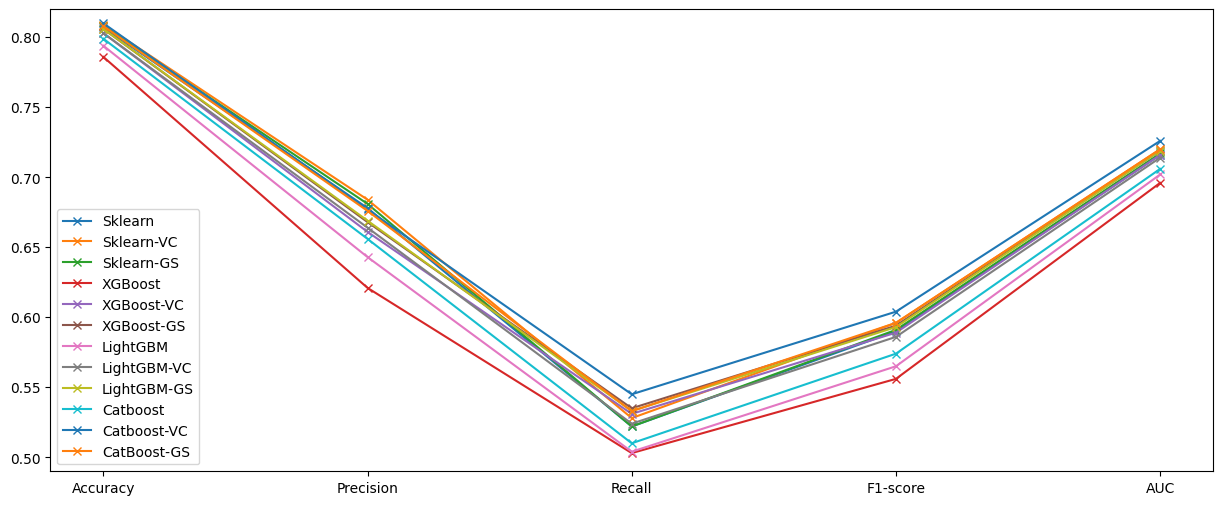

In [113]:
plt.figure(figsize=(15, 6))
x = np.arange(5)

for key, value in results.items():
    plt.plot(x, results[key], marker='x', label=key);
    
plt.xticks(x, ['Accuracy', 'Precision', 'Recall', 'F1-score', 'AUC']);
plt.ylim(0.49, 0.82)
plt.legend(prop ={'size': 10});

### Выводы

- Из коробки на первом месте реализация Sklearn, потом Catboost, затем LightGBM и XGBoost завершающий;
- После настройки параметров на первое место вышел Catboost, Sklearn переместился на второе, а третье поделили XGBoost и LightGBM с минимальным отставанием от второго места );
- Различные алгоритмы по разному определяют важность признаков;
- При этом, как мы видим, результаты рассмотренных алгоритмов достаточно близки и в целом все алгоритмы хорошо справляются со своей задачей;